# Convolutional neural networks

*Fraida Fund*

In this notebook, we will find out makes convolutional neural networks so powerful for computer vision applications!

We will use three varieties of neural networks to classify our own handwritten digits.

Note: for faster training, use Runtime \> Change Runtime Type to run this notebook on a GPU.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Rescaling, Conv2D, MaxPooling2D, Input
from keras import backend as K
from keras.datasets import mnist
from keras.utils import plot_model

In [2]:
print(tf.__version__)

2.18.0


## Import data

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [4]:
X_train.shape

(60000, 28, 28)

In [5]:
X_test.shape

(10000, 28, 28)

## Train a fully connected neural network on MNIST

*Attribution: This section is based closely on [this demo notebook by Sundeep Rangan](https://github.com/sdrangan/introml/blob/master/unit09_neural/demo2_mnist_neural_tf.ipynb)*

First, we will train a simple neural network.

We will train our neural network with early stopping, which is a kind of model selection/model tuning, so we will first split out some data for a validation set:

In [6]:
# split training set so we can use part of it for model tuning
X_tr, X_vl, y_tr, y_vl = train_test_split(X_train, y_train, test_size=1.0/6.0)

We will also need to think about pre-processing the data at the input to our network. To understand why, look at one data sample - specifically, its shape and min and max value.

In [7]:
X_tr[0].shape

(28, 28)

In [8]:
X_tr[0].min(), X_tr[0].max()

(np.uint8(0), np.uint8(255))

For a fully connected neural network, we will need to “flatten” the data from its current 28x28 shape to a 1D 784 shape, using a `Flatten` layer right after the input. We will then add a `Rescaling` layer, to rescale so that the min and max values are -1 and 1, respectively.

Then, we will have:

-   One hidden layer with $N_H=100$ units, with ReLu activation.
-   One output layer with $N_O=10$ units, one for each of the 10 possible classes. The output activation is softmax, which is used for multi-class targets.

With that in mind, we can prepare our fully connected neural network.

In [9]:
nin = X_tr[0].shape  # dimension of one sample of input data
nh = 512     # number of hidden units
nout = 10   # number of outputs
model_fc = Sequential()
model_fc.add(Input(shape=nin))
model_fc.add(Flatten())
model_fc.add(Rescaling(scale=1./127.5, offset=-1))
model_fc.add(Dense(units=nh, activation='relu', name='hidden'))
model_fc.add(Dense(units=nout, activation='softmax', name='output'))
model_fc.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden (Dense)                  │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 407,050 (1.55 MB)

 Trainable params: 407,050 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

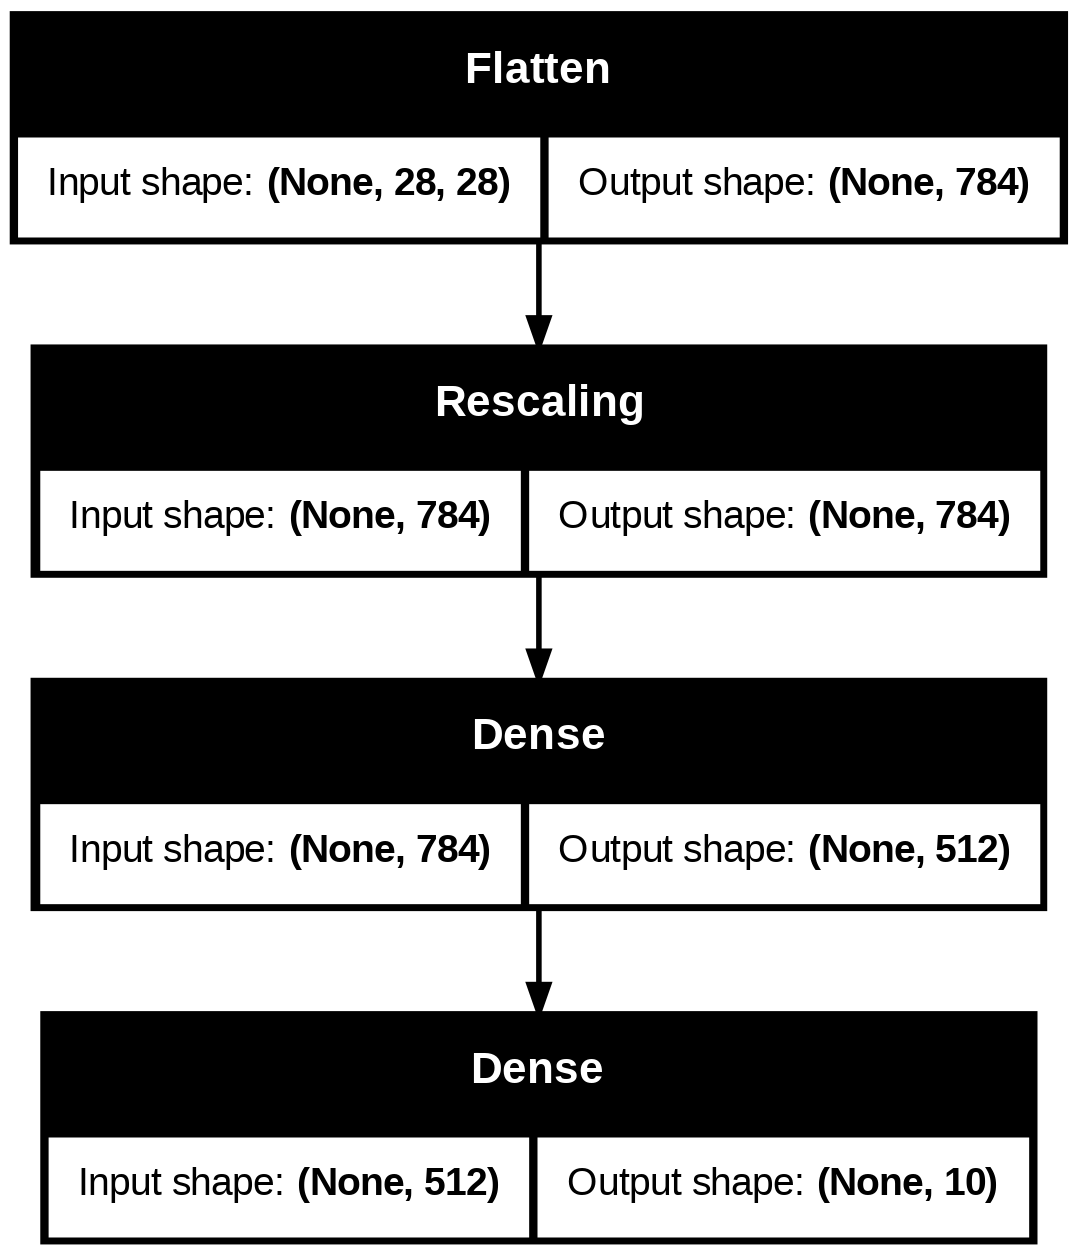

In [10]:
plot_model(model_fc, "mnist-dense.png", show_shapes=True)

To train the network, we have to select an optimizer and a loss function. Since this is a multi-class classification problem with the target variable encoded as an integer from 0 to 9, we select the `sparse_categorical_crossentropy` loss. We use the Adam optimizer for our gradient descent.

We also set the metrics that we wish to track during the optimization. In this case, we select accuracy on the training set.

In [11]:
opt = optimizers.Adam(learning_rate=0.005)
model_fc.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Finally, we are ready to train our network. We wil specify the number of epochs and the batch size. We will also use a callback function to configure the training process to stop before the configured number of epochs, if no improvement in the validation set accuracy is observed for several epochs. We will also the restore the weights that had the best performance on the validation set.

In [12]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max',
                                      patience=10,restore_best_weights=True )

Note that since the `fit` command is split across multiple lines, we cannot use the line-level magic command `%time` that we used previously to time it. Instead, we use the cell-level magic equivalent `%%time`, which reports the time to execute the entire cell

In [13]:
%%time
hist = model_fc.fit(X_tr, y_tr,
                       epochs=100, batch_size=128,
                       validation_data=(X_vl,y_vl),
                       callbacks=[es])

Epoch 1/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7712 - loss: 1.4404 - val_accuracy: 0.9316 - val_loss: 0.2191
Epoch 2/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9429 - loss: 0.1923 - val_accuracy: 0.9576 - val_loss: 0.1414
Epoch 3/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9578 - loss: 0.1355 - val_accuracy: 0.9518 - val_loss: 0.1596
Epoch 4/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9629 - loss: 0.1202 - val_accuracy: 0.9584 - val_loss: 0.1431
Epoch 5/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9663 - loss: 0.1090 - val_accuracy: 0.9622 - val_loss: 0.1305
Epoch 6/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9704 - loss: 0.0917 - val_accuracy: 0.9622 - val_loss: 0.1283
Epoch 7/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9696 - loss: 0.0965 - val_accuracy: 0.9606 - val_loss: 0.1438
Epoch 8/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9718 - loss: 0.0884 - val_accu

Next, we plot the training accuracy and validation accuracy vs. the epoch number. This helps us understand whether our network is overfitted; we may suspect overfitting if the training performance is improving with additional training epochs while the validation performance is getting worse.

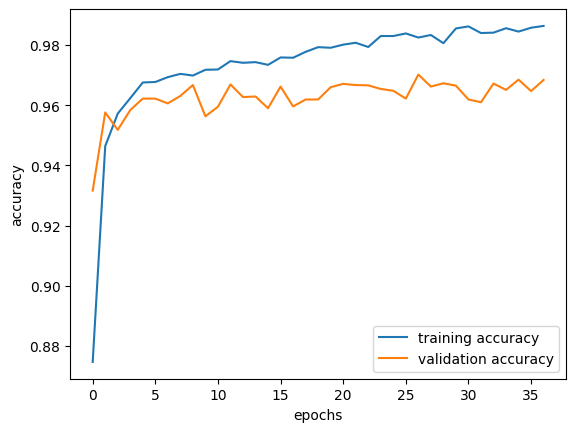

In [14]:
tr_accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']

plt.plot(tr_accuracy);
plt.plot(val_accuracy);
plt.xlabel('epochs');
plt.ylabel('accuracy');
plt.legend(['training accuracy', 'validation accuracy']);

Now we can make predictions with our fitted model:

In [15]:
%time y_pred_prob_nn = model_fc.predict(X_test)
y_pred_nn = np.argmax(y_pred_prob_nn, axis=-1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
CPU times: user 1.05 s, sys: 48.7 ms, total: 1.1 s
Wall time: 1.06 s


And compute accuracy:

In [16]:
acc = accuracy_score(y_test, y_pred_nn)
acc

0.9726

Note that we can also compute the accuracy with

In [17]:
score = model_fc.evaluate(X_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9672 - loss: 0.2011
Test score: 0.1632183939218521
Test accuracy: 0.972599983215332


Our neural network does pretty well! Currently, the state of the art (best result) on the MNIST dataset is 0.21% classification error - you can see some of the best-performing methods at [this link](https://benchmarks.ai/mnist).

Furthermore, looking at some of the samples that are misclassified by our network, we can see that many of these samples are difficult for humans to classify as well. (Some may even be labeled incorrectly!)

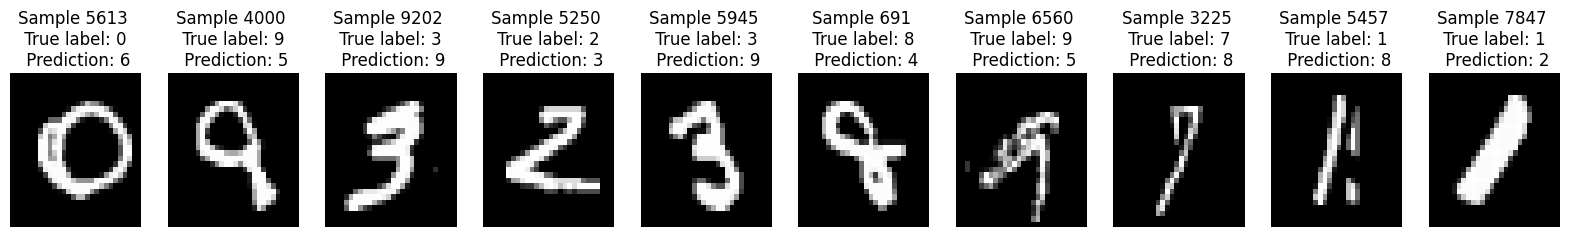

In [18]:
num_samples = 10
p = plt.figure(figsize=(num_samples*2,2))
idxs_mis = np.flatnonzero(y_test!=y_pred_nn)
idxs = np.random.choice(idxs_mis, num_samples, replace=False)
for i, idx in enumerate(idxs):
  p = plt.subplot(1, num_samples, i+1);
  p = sns.heatmap(X_test[idx].astype('uint8'), cmap=plt.cm.gray,
            xticklabels=False, yticklabels=False, cbar=False)
  p = plt.axis('off');
  p = plt.title("Sample %d \n True label: %d \n Prediction: %d" % (idx, y_test[idx], y_pred_nn[idx]));
plt.show()

## Try our fully connected neural network on our own test sample

Now, let’s try to classify our own test sample (as in a previous homework assignment).

On a plain white piece of paper, in a black or other dark-colored pen, write a digit of your choice from 0 to 9. Take a photo of your handwritten digit.

Edit your photo (crop, rotate as needed), using a photo editor of your choice (I used Google Photos), so that your photo is approximately square, and includes only the digit and the white background. Upload your image here.

In [19]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving input.png to input.png
User uploaded file "input.png" with length 7868 bytes


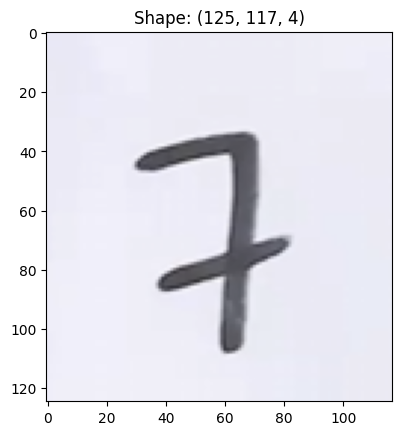

In [20]:
from PIL import Image

filename = 'input.png'

image = Image.open(filename)
p = plt.imshow(np.asarray(image), cmap=plt.cm.gray,);
p = plt.title('Shape: ' + str(np.asarray(image).shape))

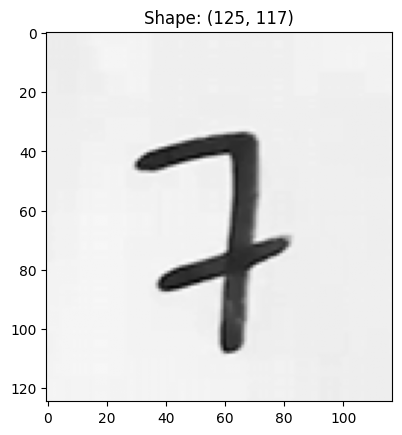

In [21]:
# convert to grayscale image - 'L' format means each pixel is
# represented by a single value from 0 to 255
image_bw = image.convert('L')
p = plt.imshow(np.asarray(image_bw), cmap=plt.cm.gray,);
p = plt.title('Shape: ' + str(np.asarray(image_bw).shape))

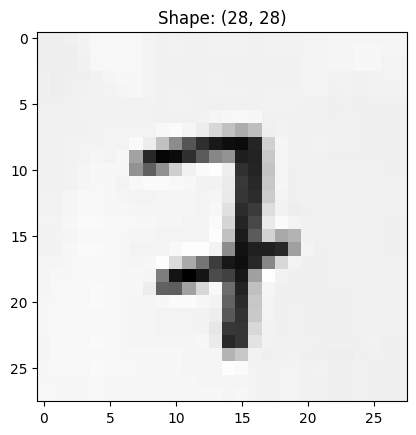

In [22]:
# resize image
image_bw_resized = image_bw.resize((28,28), Image.BICUBIC)
p = plt.imshow(np.asarray(image_bw_resized), cmap=plt.cm.gray,);
p = plt.title('Shape: ' + str(np.asarray(image_bw_resized).shape))

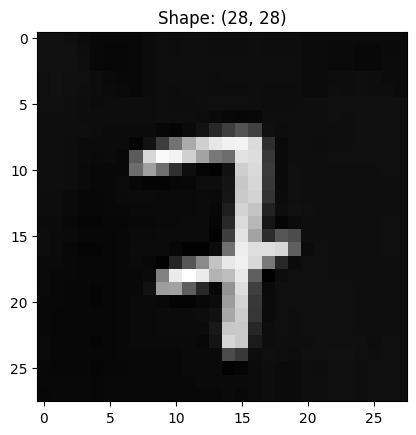

In [23]:
# invert image, to match training data
import PIL.ImageOps

image_bw_resized_inverted = PIL.ImageOps.invert(image_bw_resized)
p = plt.imshow(np.asarray(image_bw_resized_inverted), cmap=plt.cm.gray,);
p = plt.title('Shape: ' + str(np.asarray(image_bw_resized_inverted).shape))

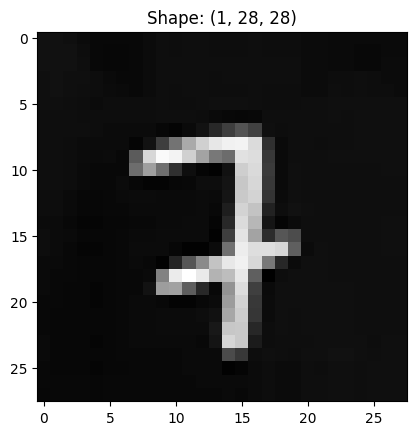

In [24]:
# finally, turn to a numpy array
test_sample = np.array(image_bw_resized_inverted).reshape(1, 28, 28)
p = plt.imshow(np.reshape(test_sample, (28,28)), cmap=plt.cm.gray,);
p = plt.title('Shape: ' + str(test_sample.shape))

Now we can predict the class of this sample:

In [25]:
test_probs = model_fc.predict(test_sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


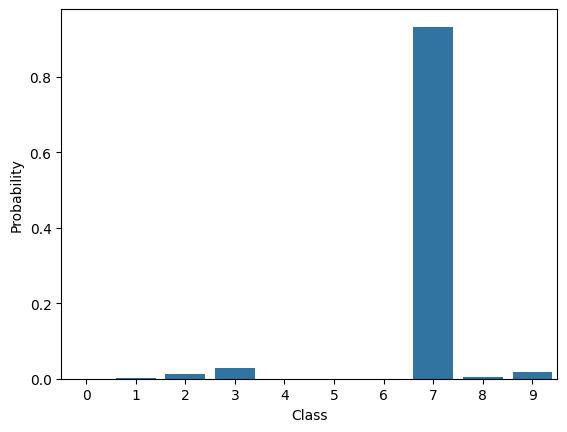

In [26]:
sns.barplot(x=np.arange(0,10), y=test_probs.squeeze());
plt.ylabel("Probability");
plt.xlabel("Class");

### Things to try

-   What if we use a test sample where the image is not so well centered?

## Background: Convolutional neural networks

The fully connected neural network was OK, but for images, there are important reasons why we will often prefer a convolutional neural network instead:

-   Dimension - images can have a huge number of pixels, and for image classification problems, we can also have a very large number of possible classes. A deep, fully connected network for these problems will have a *lot* of weights to learn.
-   Images (and videos!) have a structure that is wasted on the fully connected network.
-   Relevant features may be anywhere in the image.

The key idea behind convolutional neural networks is that a “neuron” is connected to a small part of image at a time (locally connected).

By having multiple locally connected neurons covering the entire image, we effectively “scan” the image.

What does convolution do? Let’s look at a visual example.

This is a horizontal Sobel filter, which detects horizontal edges.

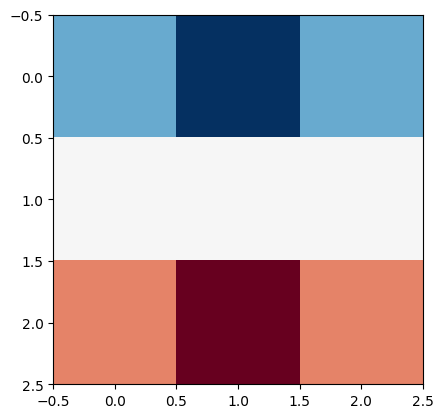

In [27]:
horizontal_sobel = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
plt.imshow(horizontal_sobel, cmap='RdBu');

This is an image of random noise:

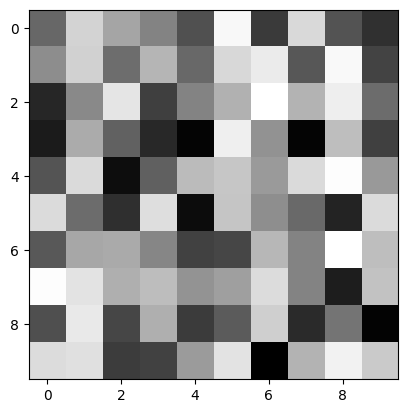

In [28]:
img = np.random.uniform(0,1,size=(10,10))
plt.imshow(img, cmap='gray');

The convolution of the Sobel filter and the random image doesn’t pick up anything interesting:

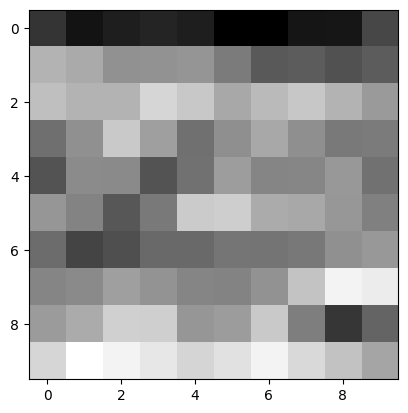

In [29]:
from scipy import signal
img_conv = signal.correlate2d(img, horizontal_sobel, mode='same')
plt.imshow(img_conv, cmap='gray');

What about the convolution of the Sobel filter and this digit?

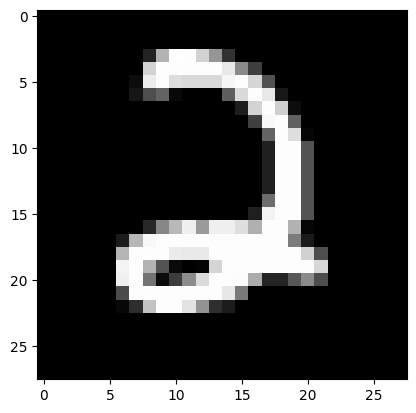

In [30]:
img_index = 3675
img = X_test[img_index]
plt.imshow(img.reshape(28,28), cmap='gray');

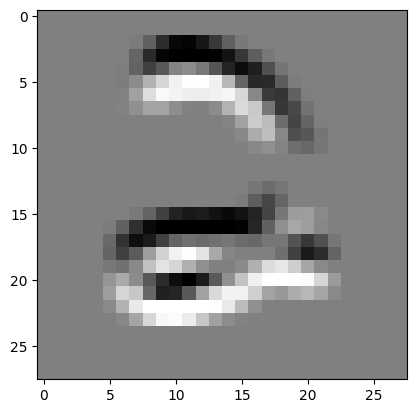

In [31]:
img_conv = signal.correlate2d(img.reshape(28,28), horizontal_sobel, mode='same')
plt.imshow(img_conv, cmap='gray');

This is a vertical Sobel filter, which detects vertical edges.

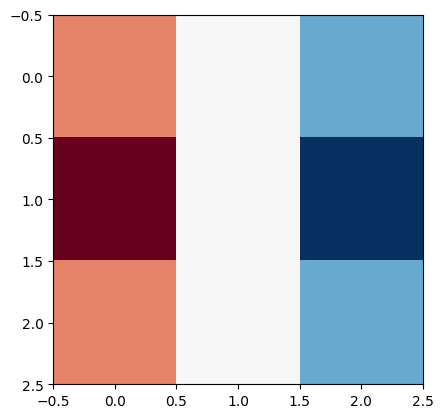

In [32]:
vertical_sobel =  np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
plt.imshow(vertical_sobel, cmap='RdBu');

Look what it finds in the digit -

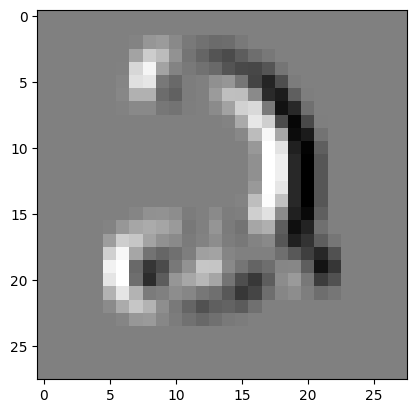

In [33]:
img_conv = signal.correlate2d(img.reshape(28,28), vertical_sobel, mode='same')
plt.imshow(img_conv, cmap='gray');

A convolutional layer is like an array of these filters - each one “sweeps” the image and looks for a different high-level “feature”.

*Attribution: this example is based on a post by [Victor Zhou](https://victorzhou.com/blog/intro-to-cnns-part-1/).*

You can see a great interactive demo of the Sobel filters in [this tutorial on edge detection](https://cse442-17f.github.io/Sobel-Laplacian-and-Canny-Edge-Detection-Algorithms/).

## Train a convolutional neural network on MNIST

*Attribution: This section is based closely on [this demo notebook by Daniel Moser](https://github.com/AviatorMoser/keras-mnist-tutorial/blob/master/MNIST%20in%20Keras.ipynb)*.

In this next section, we will train a convolutional neural network. Also, we will try to improve performance using the following techniques:

-   **Dropout layers**: Because deep networks can be prone to overfitting, we will also add *dropout* layers to our network architecture. In each training stage, a dropout layer will “zero” a random selection of outputs (just for that stage). You can read more about this technique in [this paper](http://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf).
-   **Batch normalization**: This technique re-scales and centers the data in the mini-batch when applied between layers.

We prepare our model with the same `Input` and `Rescaling` layers, but note that this time we do *not* `Flatten` the data at the input. This is followed by a sequence of `Conv2D`, `BatchNormalization`, `Activation`, `MaxPooling2D`, `Dropout`, and finally `Flatten` and `Dense` layers.

In [34]:
# Model parameters
n_filters = 32                                      # number of convolutional filters to use
pool_size = (2, 2)                                  # size of pooling area for max pooling
kernel_size = (3, 3)                                # convolution kernel size
input_shape = (28, 28, 1)                           # input image volume
n_classes = 10                                      # number of classes

model_conv = Sequential()                                 # Linear stacking of layers
model_conv.add(Input(shape=input_shape))
model_conv.add(Rescaling(scale=1./127.5, offset=-1))

# Convolution Layer 1
model_conv.add(Conv2D(32, (3, 3)))                            # 32 3x3 kernels
model_conv.add(BatchNormalization(axis=-1))               # normalize
model_conv.add(Activation('relu'))                        # activation

# Convolution Layer 2
model_conv.add(Conv2D(32, (3, 3)))                        # 32 3x3 kernels
model_conv.add(BatchNormalization(axis=-1))               # normalize
model_conv.add(Activation('relu'))                        # activation
model_conv.add(MaxPooling2D(pool_size=(2,2)))             # Pool the max values over a 2x2 kernel

# Convolution Layer 3
model_conv.add(Conv2D(64,(3, 3)))                         # 64 3x3 kernels
model_conv.add(BatchNormalization(axis=-1))               # normalize
model_conv.add(Activation('relu'))                        # activation

# Convolution Layer 4
model_conv.add(Conv2D(64, (3, 3)))                        # 64 3x3 kernels
model_conv.add(BatchNormalization(axis=-1))               # normalize
model_conv.add(Activation('relu'))                        # activation
model_conv.add(MaxPooling2D(pool_size=(2,2)))             # Pool the max values over a 2x2 kernel
model_conv.add(Flatten())                                 # Flatten final 4x4x64 output matrix into a 1024-length vector

# Fully Connected Layer 5
model_conv.add(Dense(512))                                # 512 fully connected nodes
model_conv.add(BatchNormalization())                      # normalization
model_conv.add(Activation('relu'))                        # activation

# Fully Connected Layer 6
model_conv.add(Dropout(0.2))                              # 20% dropout of randomly selected nodes
model_conv.add(Dense(10))                                 # final 10 fully connected nodes
model_conv.add(Activation('softmax'))                     # softmax activation

model_conv.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 597,738 (2.28 MB)

 Trainable params: 596,330 (2.27 MB)

 Non-trainable params: 1,408 (5.50 KB)

We will use the Adam optimizer again, and compile our model with `sparse_categorical_crossentropy` loss for backpropagation and `accuracy` for a scoring metric.

In [35]:
opt = optimizers.Adam(learning_rate=0.005)
model_conv.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Next, we repeat our Early Stopping callback. We will stop training if 10 epochs pass without an improvement in the validation accuracy, and at that point we will restore the model with the best validation accuracy seen so far.

In [36]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max',
                                      patience=10,restore_best_weights=True )

In [37]:
%%time
hist = model_conv.fit(X_tr, y_tr,
                           epochs = 100, batch_size=128,
                           validation_data=(X_vl, y_vl),
                           callbacks=[es])

Epoch 1/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.9433 - loss: 0.1815 - val_accuracy: 0.9835 - val_loss: 0.0563
Epoch 2/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.9881 - loss: 0.0380 - val_accuracy: 0.9877 - val_loss: 0.0465
Epoch 3/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9910 - loss: 0.0272 - val_accuracy: 0.9899 - val_loss: 0.0401
Epoch 4/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9928 - loss: 0.0234 - val_accuracy: 0.9906 - val_loss: 0.0378
Epoch 5/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9939 - loss: 0.0184 - val_accuracy: 0.9808 - val_loss: 0.0681
Epoch 6/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9953 - loss: 0.0142 - val_accuracy: 0.9869 - val_loss: 0.0551
Epoch 7/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9951 - loss: 0.0140 - val_accuracy: 0.9920 - val_loss: 0.0330
Epoch 8/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9959 - loss: 0.0121 - val_ac

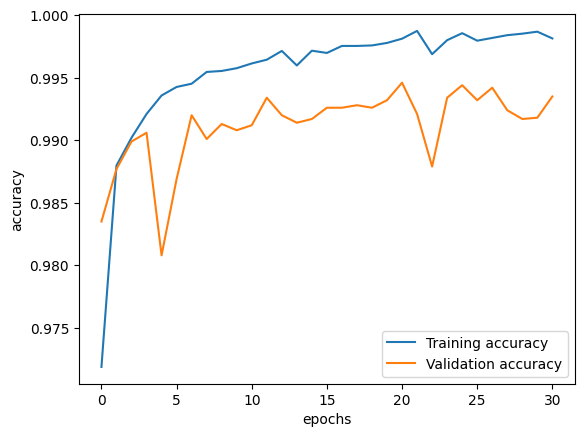

In [38]:
tr_accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']

plt.plot(tr_accuracy);
plt.plot(val_accuracy);
plt.xlabel('epochs');
plt.ylabel('accuracy');
plt.legend(['Training accuracy', 'Validation accuracy']);

In [39]:
%time y_pred_prob_conv = model_conv.predict(X_test)
y_pred_conv = np.argmax(y_pred_prob_conv, axis=-1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
CPU times: user 1.97 s, sys: 91.5 ms, total: 2.06 s
Wall time: 2.08 s


In [40]:
score = model_conv.evaluate(X_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9915 - loss: 0.0380
Test score: 0.028885766863822937
Test accuracy: 0.993399977684021


These are some of the samples that are misclassified:

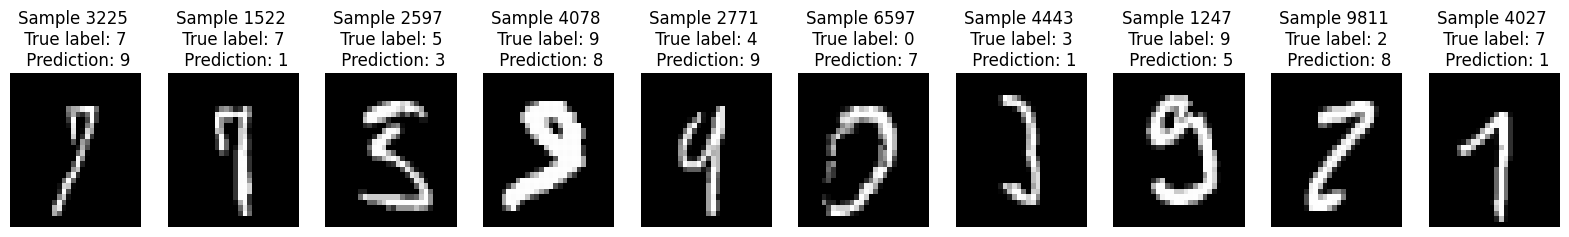

In [41]:
num_samples = 10
p = plt.figure(figsize=(num_samples*2,2))
idxs_mis = np.flatnonzero(y_test!=y_pred_conv)
idxs = np.random.choice(idxs_mis, num_samples, replace=False)
for i, idx in enumerate(idxs):
  p = plt.subplot(1, num_samples, i+1);
  p = sns.heatmap(X_test[idx].astype('uint8'), cmap=plt.cm.gray,
            xticklabels=False, yticklabels=False, cbar=False)
  p = plt.axis('off');
  p = plt.title("Sample %d \n True label: %d \n Prediction: %d" % (idx, y_test[idx], y_pred_conv[idx]));
plt.show()

## Try our convolutional neural network on our own test sample

We can use this convolutional neural network to predict the class of the test sample we uploaded previously.

In [42]:
test_probs = model_conv.predict(test_sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


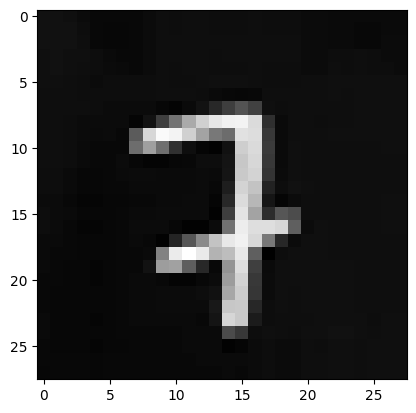

In [43]:
plt.imshow(test_sample.reshape(28, 28), cmap='gray');

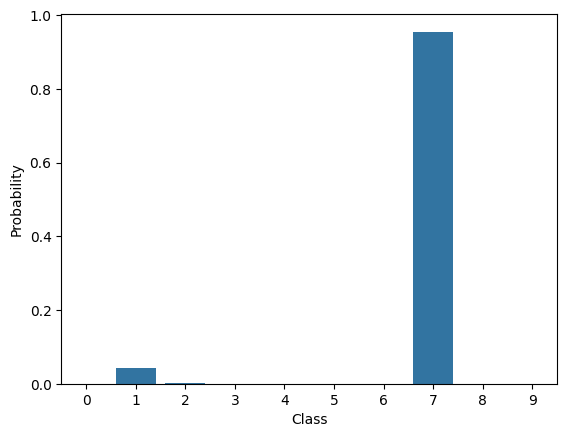

In [44]:
sns.barplot(x=np.arange(0,10), y=test_probs.squeeze());
plt.ylabel("Probability");
plt.xlabel("Class");

## Looking at output of convolutional layers

Because deep learning is so complex, it can be difficult to understand why it makes the decisions it does. One way to better understand the behavior of a neural network is to visualize the output of each layer for a given input.

We will select one input to examine:

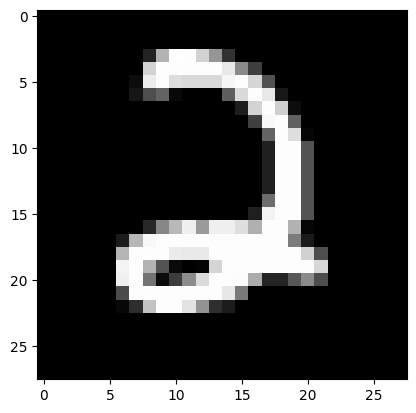

In [45]:
# choose an image to explore
img_index = 3675
img = X_test[img_index]
# add an extra dimension to it so it is in 4D
img = img.reshape(1,28,28,1)
plt.figure();
plt.imshow(img.reshape(28,28), cmap='gray', interpolation='none');

In [46]:
from ipywidgets import interactive
from ipywidgets import Layout
import ipywidgets as widgets

def plot_layer(layer_idx):

  layer_model = tf.keras.Model(inputs=model_conv.inputs,
                            outputs=model_conv.layers[layer_idx].output)
  layer_output = layer_model(X_test[img_index].reshape(1,28,28,1))
  convolutions = np.squeeze(layer_output.numpy())
  if (len(convolutions.shape)) > 1:

    m = convolutions.shape[2]
    n = int(np.ceil(np.sqrt(m)))

    # Visualization of each filter of the layer
    fig = plt.figure(figsize=(14,11))
    print(model_conv.layers[layer_idx].name)
    for i in range(m):
        ax = fig.add_subplot(n,n,i+1)
        ax.imshow(convolutions[:,:,i], cmap='gray')
    plt.show()
  else:
    pass

style = {'description_width': 'initial'}
layout = Layout(width="800px")
layer_idx = widgets.IntSlider(min=1, max=14, value=1, style=style, layout=layout)
interactive(plot_layer, layer_idx=layer_idx)

interactive(children=(IntSlider(value=1, description='layer_idx', layout=Layout(width='800px'), max=14, min=1,…

Generally, the convolutional layers close to the input capture small details, while those close to the output of the model capture more general features that are less sensitive to local variations in the input image. We can see this characteristic in the visualizations above.

For a visualization with a more interesting image, see [this notebook](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/first_edition/5.4-visualizing-what-convnets-learn.ipynb) by François Chollet.

## Saving and restoring a model

Since this model took a long time to train, it may be useful to save the results, so that we can re-use the model later without having to re-train. We can save the model in a `keras` file:

In [47]:
model_conv.save("mnist_conv_mod.keras")

Now, if you click on the folder icon in the menu on the left side of the Colab window, you can see this file in your workspace. You can download the file for later use.

To use the model again in the future, you can load it using `load_model`, then use it to make predictions without having to train it.

In [48]:
from tensorflow.keras.models import load_model

model2 = load_model("mnist_conv_mod.keras")

# use saved model to predict new samples
y_pred_prob_conv2 = model2.predict(X_test)
y_pred_conv2 = np.argmax(y_pred_prob_conv, axis=-1)
acc = accuracy_score(y_test, y_pred_conv2)
print("Accuracy of saved model on test set: %f" % acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy of saved model on test set: 0.993400


## With data augmentation

We can try one more way to improve the model performance:

-   **Data augmentation**: To supply more training samples, we can provide slightly modified versions of training samples - for example, samples with a small rotation applied - on which to train the model.

In [49]:
# Model parameters
n_filters = 32                                      # number of convolutional filters to use
pool_size = (2, 2)                                  # size of pooling area for max pooling
kernel_size = (3, 3)                                # convolution kernel size
input_shape = (28, 28, 1)                           # input image volume
n_classes = 10                                      # number of classes

model_aug = Sequential()                                 # Linear stacking of layers
model_aug.add(Input(shape=input_shape))
model_aug.add(Rescaling(scale=1./127.5, offset=-1))

# Convolution Layer 1
model_aug.add(Conv2D(32, (3, 3)))                        # 32 3x3 kernels
model_aug.add(BatchNormalization(axis=-1))               # normalize
model_aug.add(Activation('relu'))                        # activation

# Convolution Layer 2
model_aug.add(Conv2D(32, (3, 3)))                        # 32 3x3 kernels
model_aug.add(BatchNormalization(axis=-1))               # normalize
model_aug.add(Activation('relu'))                        # activation
model_aug.add(MaxPooling2D(pool_size=(2,2)))             # Pool the max values over a 2x2 kernel

# Convolution Layer 3
model_aug.add(Conv2D(64,(3, 3)))                         # 64 3x3 kernels
model_aug.add(BatchNormalization(axis=-1))               # normalize
model_aug.add(Activation('relu'))                        # activation

# Convolution Layer 4
model_aug.add(Conv2D(64, (3, 3)))                        # 64 3x3 kernels
model_aug.add(BatchNormalization(axis=-1))               # normalize
model_aug.add(Activation('relu'))                        # activation
model_aug.add(MaxPooling2D(pool_size=(2,2)) )            # Pool the max values over a 2x2 kernel
model_aug.add(Flatten())                                 # Flatten final 4x4x64 output matrix into a 1024-length vector

# Fully Connected Layer 5
model_aug.add(Dense(512))                                # 512 fully connected nodes
model_aug.add(BatchNormalization())                      # normalization
model_aug.add(Activation('relu'))                        # activation

# Fully Connected Layer 6
model_aug.add(Dropout(0.2))                              # 20% dropout of randomly selected nodes
model_aug.add(Dense(10))                                 # final 10 fully connected nodes
model_aug.add(Activation('softmax'))                     # softmax activation

model_aug.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 24, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         5,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 597,738 (2.28 MB)

 Trainable params: 596,330 (2.27 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [50]:
opt = optimizers.Adam(learning_rate=0.005)
model_aug.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In the following cell, we will use the `image` functions in Tensorflow for data augmentation. This function will generate versions of the training images that have some image effects applied: brightness, contrast, and crop (and then resize back to the expected shape).

We will set up a dataset “pipeline” that gets images in batches from memory, applies the augmentation, then passes the augmented images to the model.

Note that the augmentation is applied only to the training data, not to validation or test data.

In [51]:
def augment_images(image, label):
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    image = tf.image.random_crop(
    image, size=(image.shape[0] - 4, image.shape[1] - 4, image.shape[2])
    )
    image = tf.image.resize(image, [28,28])
    return image, label

tr_ds = tf.data.Dataset.from_tensor_slices((X_tr.reshape(-1,28,28,1), y_tr))
tr_ds = tr_ds.shuffle(buffer_size=1000).map(
    augment_images, num_parallel_calls=tf.data.AUTOTUNE
).batch(128).prefetch(tf.data.AUTOTUNE)

vl_ds = tf.data.Dataset.from_tensor_slices((X_vl.reshape(-1,28,28,1), y_vl))
vl_ds = vl_ds.batch(128).prefetch(tf.data.AUTOTUNE)

ts_ds = tf.data.Dataset.from_tensor_slices((X_test.reshape(-1,28,28,1), y_test))
ts_ds = ts_ds.batch(128).prefetch(tf.data.AUTOTUNE)


To train our model with data augmentation, we will use the `fit` function and pass our dataset.

In [52]:
%%time
hist = model_aug.fit(tr_ds,
                          epochs = 100,
                          validation_data = vl_ds,
                          callbacks=[es])

Epoch 1/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - accuracy: 0.9114 - loss: 0.2863 - val_accuracy: 0.9459 - val_loss: 0.1697
Epoch 2/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9784 - loss: 0.0708 - val_accuracy: 0.9452 - val_loss: 0.1954
Epoch 3/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9833 - loss: 0.0557 - val_accuracy: 0.8282 - val_loss: 0.6024
Epoch 4/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9849 - loss: 0.0498 - val_accuracy: 0.9812 - val_loss: 0.0608
Epoch 5/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9869 - loss: 0.0420 - val_accuracy: 0.9878 - val_loss: 0.0410
Epoch 6/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9881 - loss: 0.0386 - val_accuracy: 0.9792 - val_loss: 0.0691
Epoch 7/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9901 - loss: 0.0319 - val_accuracy: 0.9827 - val_loss: 0.0551
Epoch 8/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9906 - loss: 0.0303 -

In [53]:
score = model_aug.evaluate(ts_ds)

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9884 - loss: 0.0350


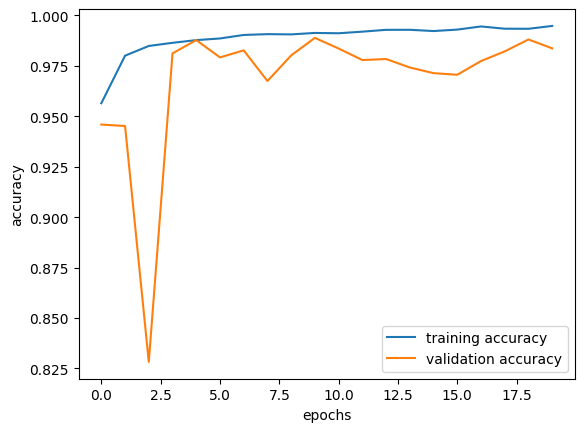

In [54]:
tr_accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']

plt.plot(tr_accuracy);
plt.plot(val_accuracy);
plt.xlabel('epochs');
plt.ylabel('accuracy');
plt.legend(['training accuracy', 'validation accuracy']);

In [55]:
%time y_pred_prob_aug = model_aug.predict(X_test)
y_pred_aug = np.argmax(y_pred_prob_aug, axis=-1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
CPU times: user 1.56 s, sys: 79.9 ms, total: 1.64 s
Wall time: 1.52 s


In [56]:
score = model_aug.evaluate(ts_ds)
print('Test score:', score[0])
print('Test accuracy:', score[1])

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9884 - loss: 0.0350
Test score: 0.029908770695328712
Test accuracy: 0.9901999831199646


These are some misclassified samples of this network:

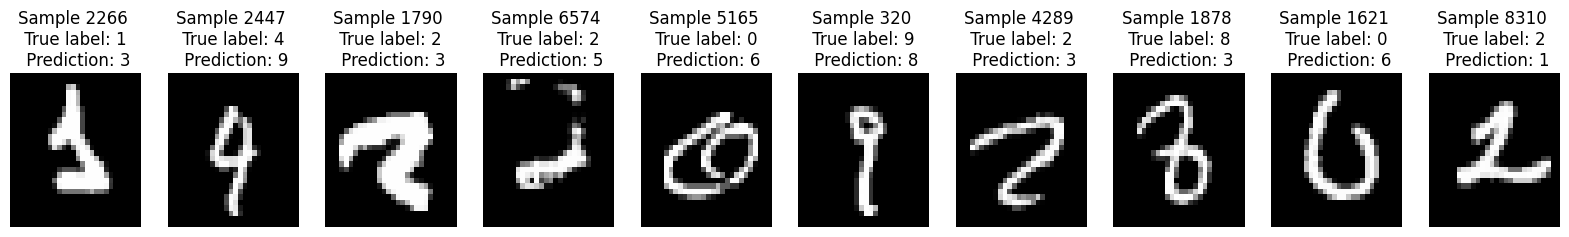

In [57]:
num_samples = 10
p = plt.figure(figsize=(num_samples*2,2))
idxs_mis = np.flatnonzero(y_test!=y_pred_aug)
idxs = np.random.choice(idxs_mis, num_samples, replace=False)
for i, idx in enumerate(idxs):
  p = plt.subplot(1, num_samples, i+1);
  p = sns.heatmap(X_test[idx].astype('uint8'), cmap=plt.cm.gray,
            xticklabels=False, yticklabels=False, cbar=False)
  p = plt.axis('off');
  p = plt.title("Sample %d \n True label: %d \n Prediction: %d" % (idx, y_test[idx], y_pred_aug[idx]));
plt.show()

Now, let’s see its performance on our own test sample:

In [58]:
test_probs = model_aug.predict(test_sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


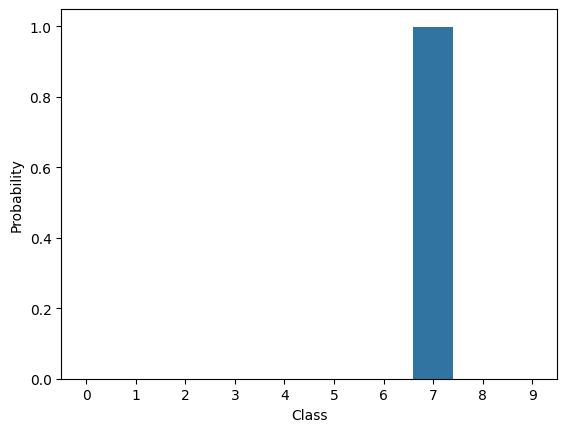

In [59]:
sns.barplot(x=np.arange(0,10), y=test_probs.squeeze());
plt.ylabel("Probability");
plt.xlabel("Class");

## Try more of your own test samples!

In [69]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving input2.png to input2.png
User uploaded file "input2.png" with length 5838 bytes


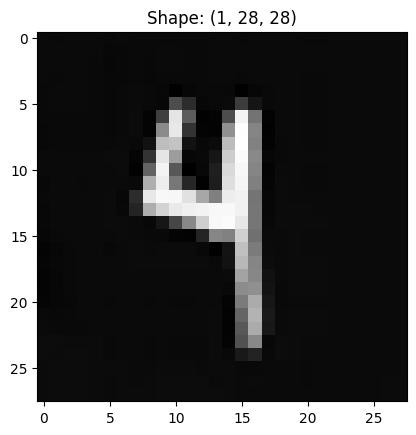

In [70]:
from PIL import Image

filename = 'input2.png'

image = Image.open(filename)
image_bw = image.convert('L')
image_bw_resized = image_bw.resize((28,28), Image.BICUBIC)
image_bw_resized_inverted = PIL.ImageOps.invert(image_bw_resized)
test_sample = np.array(image_bw_resized_inverted).reshape(1, 28, 28)
p = plt.imshow(np.reshape(test_sample, (28,28)), cmap=plt.cm.gray,);
p = plt.title('Shape: ' + str(test_sample.shape))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


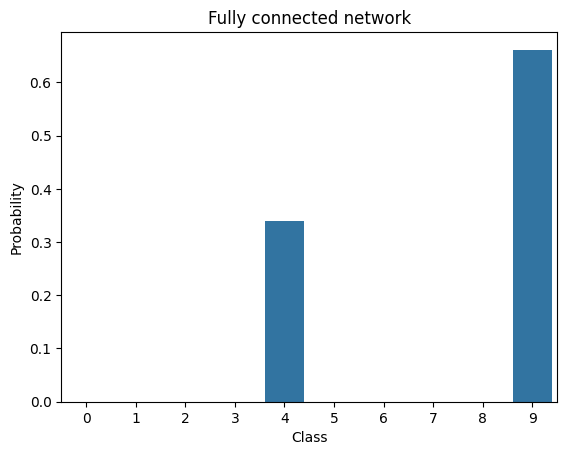

In [71]:
test_probs = model_fc.predict(test_sample)
sns.barplot(x=np.arange(0,10), y=test_probs.squeeze());
plt.ylabel("Probability");
plt.xlabel("Class");
plt.title("Fully connected network");

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


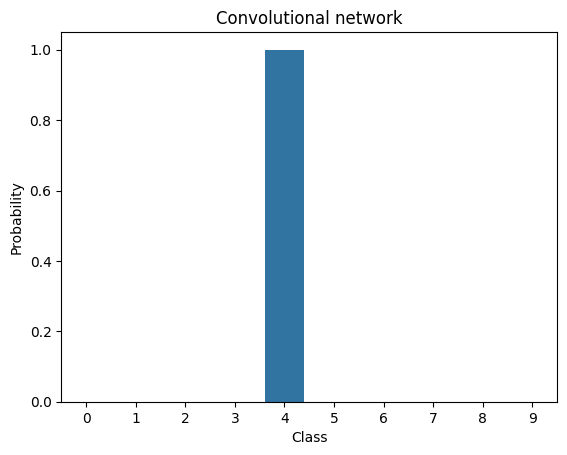

In [72]:
test_probs = model_conv.predict(test_sample)
sns.barplot(x=np.arange(0,10), y=test_probs.squeeze());
plt.ylabel("Probability");
plt.xlabel("Class");
plt.title("Convolutional network");

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


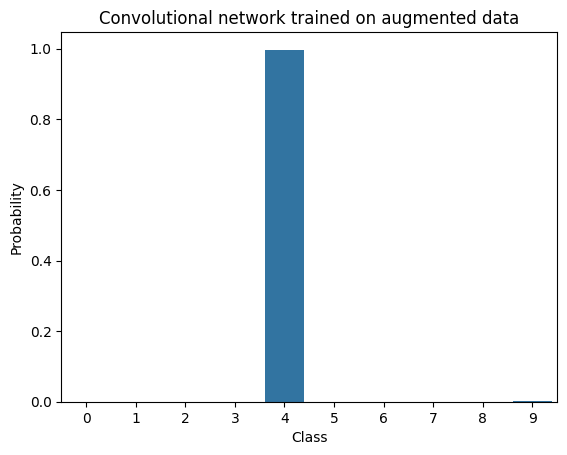

In [73]:
test_probs = model_aug.predict(test_sample)
sns.barplot(x=np.arange(0,10), y=test_probs.squeeze());
plt.ylabel("Probability");
plt.xlabel("Class");
plt.title("Convolutional network trained on augmented data");

## More things to try

-   This notebook runs using a free GPU on Colab! Try changing the runtime to CPU: Runtime \> Change Runtime Type and change Hardware Accelerator to CPU. Then run the notebook again. How much speedup did you get with the GPU, relative to CPU?